# **Laporan Proyek Machine Learning - Ivan Setya Ananda**

# **Project Overview**

### **Context:**

Loyalitas pelanggan merupakan salah satu aspek penting yang menentukan keberhasilan sebuah perusahaan, terutama dalam industri perbankan yang sangat kompetitif. Pemahaman terhadap faktor-faktor yang memengaruhi keputusan pelanggan untuk tetap menggunakan layanan atau meninggalkan bank menjadi hal yang krusial.

Dataset ini menyajikan informasi rinci tentang pelanggan sebuah bank, termasuk data demografi, perilaku keuangan, dan hubungan mereka dengan bank. Variabel target dalam dataset ini berupa variabel biner yang mencerminkan status pelanggan, yaitu apakah mereka masih aktif menggunakan layanan bank atau telah memutuskan untuk menutup akun mereka.

Dengan menganalisis data ini, diharapkan dapat diperoleh wawasan mendalam mengenai pola dan faktor yang berkontribusi terhadap keputusan pelanggan untuk meninggalkan bank. Informasi ini dapat membantu bank mengembangkan strategi yang lebih efektif untuk meningkatkan retensi pelanggan dan mengurangi tingkat pengabaian (customer churn), sehingga mendukung pertumbuhan bisnis secara berkelanjutan.

Target :

0 : Customer tidak churn

1 : Customer churn

### **Dataset overview:**


Dataset : https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
- Terdiri dari 10.000 observasi dan 12 variabel.
- Variabel independen berisi informasi tentang pelanggan.
- Variabel dependen merujuk pada pengabaian pelanggan.

## **Business Understanding**

### **Problem Statements:**

- Faktor apa saja yang memungkinkan customer untuk churn?
- Bagaimana perusahaan dapat mengurangi cost dari potensi customer yang churn?

### **Goals:**
- Mencari tahu variabel apa saja yang mempengaruhi customer churn
- Memprediksi kemungkinan seorang customer akan churn/tidak

### **Solution Approach:**


Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan customer akan melakukan churn atau tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang customer yang berpotensi churn/tidak.

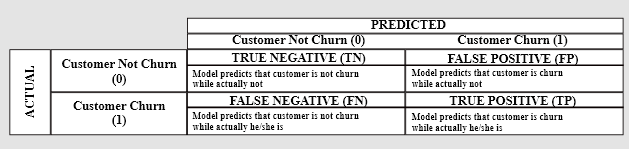

Type 1 error : False Positive
Konsekuensi: customer churn yang tidak diketahui

Type 2 error : False Negative
Konsekuensi: hilangnya customer loyal

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi hilangnya customer loyal dan salah memprediksi bahwa customer yang tidak churn terindikasikan churn karena akan memakan lebih banyak cost untuk mengembalikan customer potensial. Jadi harus difokuskan terhadap recall. Jadi nanti metric utama yang bisa digunakan adalah F2-Score.

# **Data Understanding**

- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany/ France/ Spain)
- Gender: Gender (Female/ Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: The number of bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Churn or not? (0 = No, 1 = Yes)

# **Data Preparation**

In [ ]:
# !pip install category_encoders
# !pip install imblearn
# !pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
# from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, recall_score, fbeta_score, make_scorer
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, recall_score, fbeta_score, make_scorer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shrutimechlearn/churn-modelling

!unzip churn-modelling.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
License(s): unknown
  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 148MB/s]
Archive:  churn-modelling.zip
  inflating: Churn_Modelling.csv     


In [ ]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# mild imbalance
print(df['Exited'].value_counts())
print()
print(df['Exited'].value_counts()/len(df['Exited'])*100)

Exited
0    7963
1    2037
Name: count, dtype: int64

Exited
0    79.63
1    20.37
Name: count, dtype: float64


In [ ]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Surname', 'Geography', 'Gender']

In [ ]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in Surname:  2932
Unique values:  ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Total unique values in Geography:  3
Unique values:  ['France' 'Spain' 'Germany']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']



In [ ]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Exited']))]
num_features

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [ ]:
df['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [ ]:
df.groupby('Geography').sum()['Exited']

,Exited
Geography,
France,810
Germany,814
Spain,413


In [ ]:
df.isna().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
sns.set_palette('Set1')

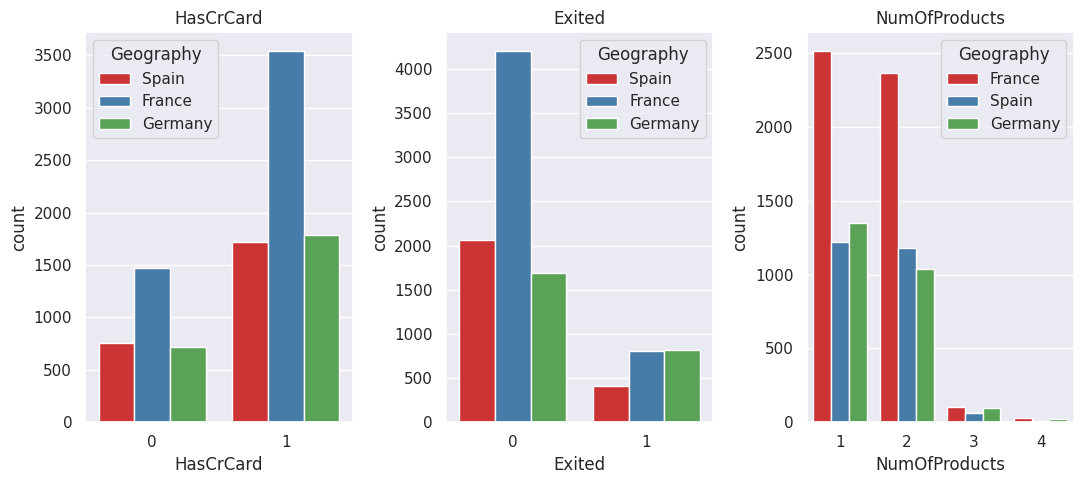

In [ ]:
# Jumlah nasabah untuk tiap categorical variables, dibagi berdasarkan asal negaranya
features = ['HasCrCard', 'Exited', 'NumOfProducts']
plt.figure(figsize=(11, 5))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(1, 3, plotnumber)
    sns.countplot(x=feature, hue='Geography', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

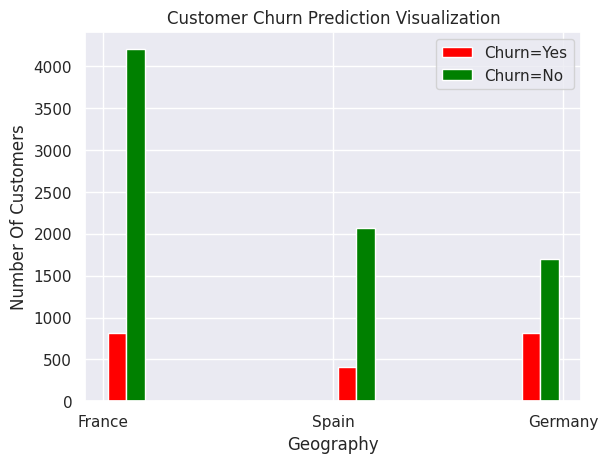

In [ ]:
# Perbandingan churn customers pada tiap negara
geo_churn_no = df[df.Exited==0]['Geography']
geo_churn_yes = df[df.Exited==1]['Geography']

plt.xlabel('Geography')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([geo_churn_yes, geo_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

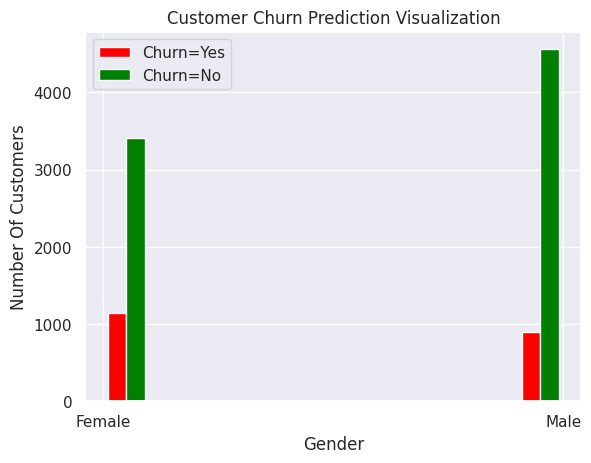

In [ ]:
# Perbandingan churn customers pada tiap gender

gender_churn_no = df[df.Exited==0]['Gender']
gender_churn_yes = df[df.Exited==1]['Gender']

plt.xlabel('Gender')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([gender_churn_yes, gender_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

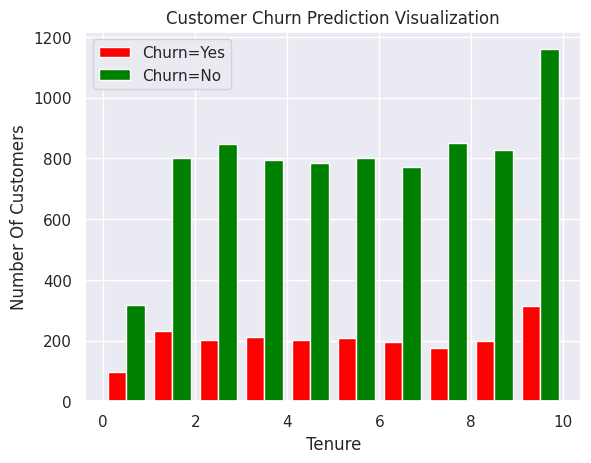

In [ ]:
# Perbandingan churn customers untuk tiap lama tahun Tenure/masa cicilan

tenure_churn_no = df[df.Exited==0].Tenure
tenure_churn_yes = df[df.Exited==1].Tenure

plt.xlabel('Tenure')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([tenure_churn_yes, tenure_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

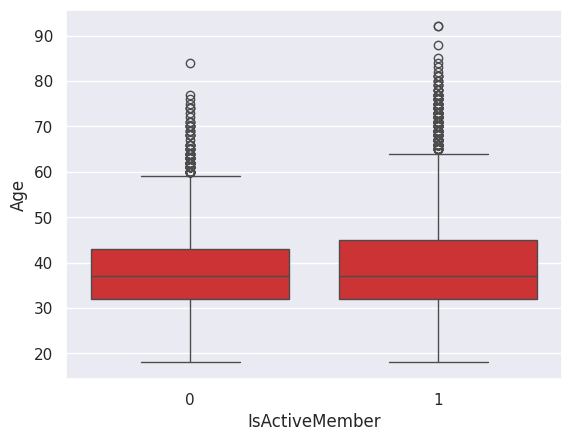

In [ ]:
# sebaran umur pada active member dan non-active member
sns.boxplot(x='IsActiveMember', y='Age', data=df);

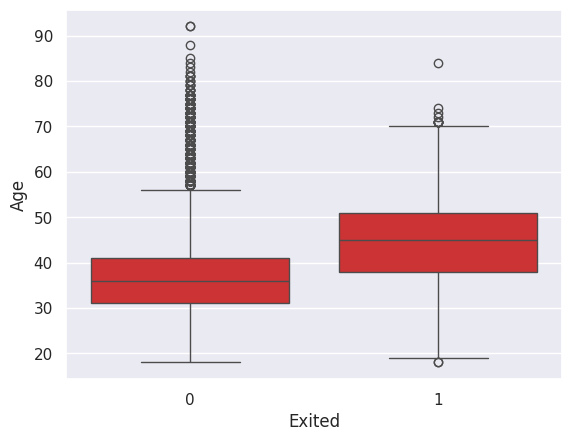

In [ ]:
# sebaran umur pada churn customer dan non-churn customer
sns.boxplot(x='Exited', y='Age', data=df);

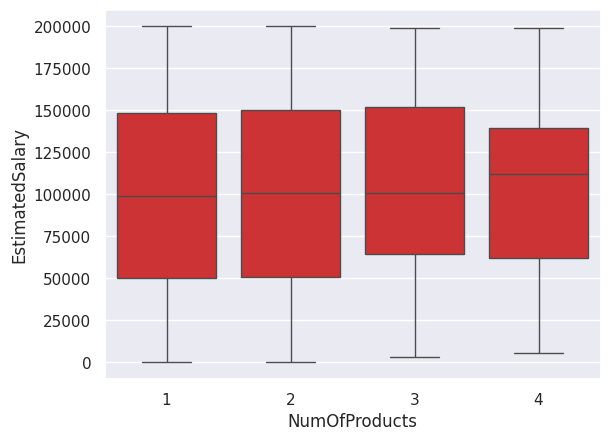

In [ ]:
# sebaran gaji pada tiap jumlah product yang digunakan oleh nasabah

sns.boxplot(x='NumOfProducts', y='EstimatedSalary', data=df);

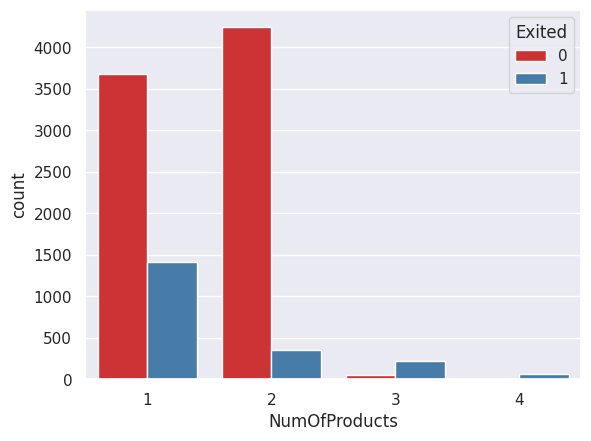

In [ ]:
sns.countplot(x='NumOfProducts', hue='Exited', data=df);

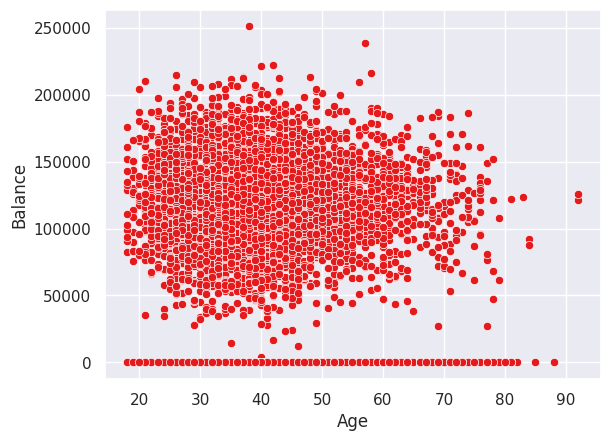

In [ ]:
# korelasi antara umur dan saldo
sns.scatterplot(x='Age', y='Balance', data=df);

In [ ]:
# Drop some columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# **Modeling**

In [ ]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=0
)

In [ ]:
# Transformer scheme
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['Geography', 'Gender'])
], remainder='passthrough')

Mengubah kolom kategori menjadi representasi biner (0 dan 1) karena model tidak bisa memproses nilai kategorikal.

In [ ]:
# resampling
smote = SMOTE(random_state=0)
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)


Melakukan imbalancing supaya data pada kedua values memiliki nilai yang bobot yang hampir sama.

In [ ]:
# DecsionTree
tree = DecisionTreeClassifier(random_state=0)

# RandomForest
rf = RandomForestClassifier(random_state=0)

# Adaboost
ada = AdaBoostClassifier(tree, random_state=0)

# Gradientboost
gbc = GradientBoostingClassifier(random_state=0)

# ExtremeGradientBoost
xgbc = XGBClassifier(random_state=0, verbosity=0)

In [ ]:
# Define imbalanced treatment method
models = [tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

# F2 score (Karena cost dari FN (diprediksi tidak churn, padahal aslinya churn) lebih tinggi dari pada FP (diprediksi churn, padahal aslinya tidak churn))
f2_score = make_scorer(fbeta_score, beta=2)

for i in models:

    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('transformer', transformer),
        ('scaler', RobustScaler()),
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=skfold,
        scoring=f2_score,
        error_score='raise'
        )

    print(model_cv, i)

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

[0.56503826 0.55754323 0.56169965 0.56488992 0.51153164] DecisionTreeClassifier(random_state=0)
[0.60012438 0.60274828 0.62770563 0.60513447 0.54790232] RandomForestClassifier(random_state=0)
[0.56924883 0.57498518 0.55131965 0.55878929 0.50942285] AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=0),
                   random_state=0)
[0.65033273 0.64564565 0.66185319 0.64217443 0.63946407] GradientBoostingClassifier(random_state=0)
[0.57485786 0.57728707 0.57934509 0.58052434 0.56925996] XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
      

In [ ]:
pd.DataFrame({
    'model':['tree', 'rf',' ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,tree,0.552141,0.020487
1,rf,0.596723,0.026314
2,ada,0.552753,0.023162
3,gbc,0.647894,0.007869
4,xgbc,0.576255,0.003993


Model GradientBoost dan XGBoost dipilih menjadi 2 model paling optimal karena memiliki nilai recall rata-rata paling tinggi dan standar deviasi terendah.

## **Gradient Boosting**

In [ ]:
list(np.arange(2,10)/10)

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
# kedalaman pohon
max_depth = list(np.arange(1,10))

# learning rate
learning_rate = list(np.arange(1,100)/100)

# jumlah pohon
n_estimators = list(np.arange(50,500))

# jumlah baris train set tiap pohon (% dari total baris train set)
subsample = list(np.arange(2,10)/10)

# jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)
max_features = list(np.arange(1,10))

# Hyperparameter space GBC
hyperparam_space_gbc = {
    'balancing':[smote, rus, ros, None],
    'model__max_depth':max_depth ,
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__max_features':max_features
}

In [ ]:
# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Benchmark model 1
gbc = GradientBoostingClassifier(random_state=0)

# Create the algorithm chains
estimator_gbc = Pipeline([
    ('tansformer', transformer),
    ('scaler', RobustScaler()),
    ('balancing', smote),
    ('model', gbc)
    ])

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc,
    param_distributions = hyperparam_space_gbc,
    cv = skf,
    scoring = f2_score,
    n_jobs = -1,
    random_state=0,
    n_iter=30
)

In [ ]:
random_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('scaler', RobustScaler()),
                                             ('balancing',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              GradientBoostingClassifier(random_st...
                                                                 0.27, 0.28,
                                                                 0.29, 0.3, ...],
                                        'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'model__max_features': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9],
                                        'model__n_estimators': [50, 51, 52, 53,
                                                                54, 55, 56, 57,
                                                                58, 59, 60, 61,
                                                                62, 63, 64, 65,
                                                                66, 67, 68, 69,
                                                                70, 71, 72, 73,
                                                                74, 75, 76, 77,
                                                                78, 79, ...],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [ ]:
pd.DataFrame(random_gbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_model__learning_rate,param_balancing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.375871,0.029596,0.020831,0.008903,0.4,107,1,4,0.26,RandomUnderSampler(random_state=0),"{'model__subsample': 0.4, 'model__n_estimators...",0.655471,0.676998,0.686543,0.651226,0.671883,0.668424,0.013246,1
23,6.331452,0.558448,0.068561,0.022592,0.7,461,5,7,0.27,RandomUnderSampler(random_state=0),"{'model__subsample': 0.7, 'model__n_estimators...",0.682914,0.665746,0.674712,0.651466,0.660636,0.667095,0.010918,2
3,0.372133,0.008888,0.012294,0.000909,0.5,65,8,1,0.12,RandomOverSampler(random_state=0),"{'model__subsample': 0.5, 'model__n_estimators...",0.681313,0.674536,0.687743,0.633880,0.647059,0.664906,0.020807,3
11,3.115954,0.808314,0.021790,0.006612,0.8,486,4,1,0.50,RandomOverSampler(random_state=0),"{'model__subsample': 0.8, 'model__n_estimators...",0.680066,0.658192,0.655192,0.656650,0.651319,0.660284,0.010151,4
4,1.473013,0.026689,0.018515,0.002121,0.5,56,3,8,0.03,RandomOverSampler(random_state=0),"{'model__subsample': 0.5, 'model__n_estimators...",0.690962,0.655152,0.668622,0.635569,0.633511,0.656763,0.021460,5


In [ ]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)


GBC
Best_score: 0.6684243835694239
Best_params: {'model__subsample': 0.4, 'model__n_estimators': 107, 'model__max_features': 1, 'model__max_depth': 4, 'model__learning_rate': 0.26, 'balancing': RandomUnderSampler(random_state=0)}


## **XGBoost**

In [ ]:
# kedalaman pohon
max_depth = list(np.arange(1,11))

# learning rate
learning_rate = list(np.arange(0.01, 1.0, 0.01))

# jumlah pohon
n_estimators = list(np.arange(100,201))

# jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(0.2, 1.0, 0.1))

# gamma (min_impurity_decrease)
gamma = list(np.arange(1,11))

# jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(0.1, 1.0, 0.2))

# alpha (regularization)
reg_alpha = list(np.logspace(-3,3,7))


# Hyperparam space XGboost
hyperparam_space_xgbc = {
    'balancing':[smote, rus, ros, None],
    'model__max_depth':max_depth,
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [ ]:
# Benchmark model 2
xgbc = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgbc = Pipeline([
        ('tansformer', transformer),
        ('balancing', smote),
        ('model', xgbc)
        ])

# Hyperparameter tuning
random_xgbc = RandomizedSearchCV(
    estimator_xgbc,
    param_distributions = hyperparam_space_xgbc,
    cv = skf,
    scoring = f2_score,
    n_jobs = -1,
    random_state=0,
    n_iter=30
)

In [ ]:
random_xgbc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('tansformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('balancing',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            cols...
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'model__reg_alpha': [0.001, 0.01,
                                                             0.09999999999999999,
                                                             1.0, 10.0, 100.0,
                                                             1000.0],
                                        'model__subsample': [0.2,
                                                             0.30000000000000004,
                                                             0.4000000000000001,
                                                             0.5000000000000001,
                                                             0.6000000000000001,
                                                             0.7000000000000002,
                                                             0.8000000000000003,
                                                             0.9000000000000001]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [ ]:
pd.DataFrame(random_xgbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,param_balancing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.090207,0.001355,0.013219,0.000461,0.9,0.01,194,3,0.22,2,...,RandomUnderSampler(random_state=0),"{'model__subsample': 0.9000000000000001, 'mode...",0.705234,0.687044,0.705128,0.662417,0.665921,0.685149,0.018399,1
14,0.258182,0.078095,0.019366,0.007447,0.9,0.10,144,8,0.65,8,...,RandomOverSampler(random_state=0),"{'model__subsample': 0.9000000000000001, 'mode...",0.681191,0.675223,0.663494,0.658402,0.673344,0.670331,0.008246,2
25,0.393364,0.114832,0.045531,0.019706,0.4,0.10,151,3,0.24,2,...,RandomUnderSampler(random_state=0),"{'model__subsample': 0.4000000000000001, 'mode...",0.697425,0.673077,0.672867,0.643836,0.644273,0.666295,0.020237,3
29,0.066977,0.005371,0.011270,0.001593,0.4,1.00,133,7,0.49,3,...,RandomUnderSampler(random_state=0),"{'model__subsample': 0.4000000000000001, 'mode...",0.689278,0.664997,0.661683,0.653128,0.660998,0.666017,0.012265,4
3,0.082791,0.002103,0.011937,0.000235,0.5,1.00,189,5,0.82,9,...,RandomUnderSampler(random_state=0),"{'model__subsample': 0.5000000000000001, 'mode...",0.661646,0.683196,0.667211,0.672201,0.645339,0.665919,0.012501,5


In [ ]:
print('XGBoost')
print('Best_score:', random_xgbc.best_score_)
print('Best_params:', random_xgbc.best_params_)

XGBoost
Best_score: 0.6851488121818872
Best_params: {'model__subsample': 0.9000000000000001, 'model__reg_alpha': 0.01, 'model__n_estimators': 194, 'model__max_depth': 3, 'model__learning_rate': 0.22, 'model__gamma': 2, 'model__colsample_bytree': 0.5000000000000001, 'balancing': RandomUnderSampler(random_state=0)}


f2 score di train set:
- benchmark model gradient boost: 0.647
- hyperparameter tuning gradient boost: 0.668
- hyperparameter tuning XGBoost: 0.685


In [ ]:
models={
    'GradientBoosting': GradientBoostingClassifier(random_state=0),
    'XGBoost': XGBClassifier(random_state=0, verbosity=0)
}

score=[]

for i in models:

    model = Pipeline([
        ('transformer', transformer),
        ('balancing', smote),
        ('model', models[i])
    ])

    # fitting
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # recall score
    score.append([fbeta_score(y_test, y_pred, beta=2)])

score_before_tuning = pd.DataFrame(score, columns=['F2 score'], index = models.keys())
score_before_tuning


,F2 score
GradientBoosting,0.531527
XGBoost,0.523165


In [ ]:
# best model
gbc_tuning = random_gbc.best_estimator_

# fitting
gbc_tuning.fit(X_train, y_train)

# predict
y_pred_gbc_tuning = gbc_tuning.predict(X_test)

# recall score
f2score_gbc_tuning = fbeta_score(y_test, y_pred_gbc_tuning, beta=2)
f2score_gbc_tuning

0.6577777777777778

In [ ]:
# best model
xgbc_tuning = random_xgbc.best_estimator_

# fitting
xgbc_tuning.fit(X_train, y_train)

# predict
y_pred_xgbc_tuning = xgbc_tuning.predict(X_test)

# recall score
f2score_xgbc_tuning = fbeta_score(y_test, y_pred_xgbc_tuning, beta=2)
f2score_xgbc_tuning

0.6632425189816883

In [ ]:
score_list = [f2score_gbc_tuning, f2score_xgbc_tuning]

models = ['GradientBoosting', 'XGBoost']

score_after_tuning = pd.DataFrame({
    'Model': models,
    'F2 score': score_list
})

score_after_tuning

,Model,F2 score
0,GradientBoosting,0.657778
1,XGBoost,0.663243


## Evaluation

In [ ]:
score_before_tuning

,F2 score
GradientBoosting,0.531527
XGBoost,0.523165


In [ ]:
score_after_tuning

,Model,F2 score
0,GradientBoosting,0.657778
1,XGBoost,0.663243


In [ ]:
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1593
           1       0.48      0.73      0.58       407

    accuracy                           0.78      2000
   macro avg       0.70      0.76      0.71      2000
weighted avg       0.83      0.78      0.80      2000



In [ ]:
print('XGBoost')
print(classification_report(y_test, y_pred_xgbc_tuning))

XGBoost
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.49      0.73      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.79      0.80      2000



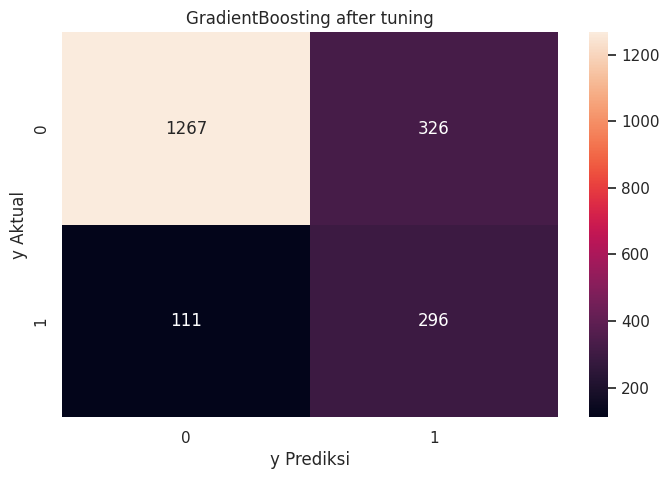

In [ ]:
# GradientBoost after tuning
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GradientBoosting after tuning');

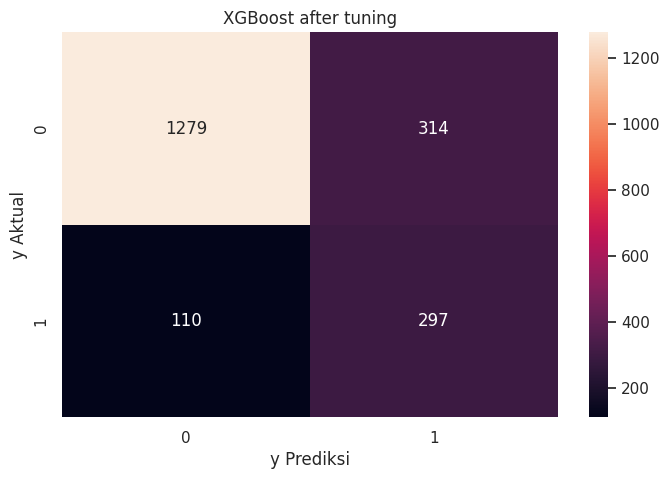

In [ ]:
# Model XGBoost after tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost after tuning');

In [ ]:
print(score_before_tuning.iloc[0])
print(score_after_tuning.iloc[0])


F2 score    0.531527
Name: GradientBoosting, dtype: float64
Model       GradientBoosting
F2 score            0.657778
Name: 0, dtype: object


In [ ]:
xgbc_tuning

Pipeline(steps=[('tansformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('balancing', RandomUnderSampler(random_state=0)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5000000000000001, de...
                               feature_types=None, gamma=2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.22,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=194, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

### **Summary**
---
Gradient Boost

   - Train Set:
      - Before tuning: 0.65
      - After tuning: 0.67

   - Test Set:
      - Before tuning: 0.53
      - After tuning: 0.66

---
XGBoost

   - Train Set:
      - Before tuning: 0.58
      - After tuning: 0.68

   - Test Set:
      - Before tuning: 0.52
      - After tuning: 0.67

---

Hyperparameter tuning berhasil meningkatkan F2 Score pda test set dari model dengan XGBoost sebesar 0.15.
Performa model sebesar 0.67 bisa dikatakan belum bagus karena jumlah False Negative masih sekitar 1/4 dari total kelas 1 (churn).



Metric F2 Score digunakan karena cost function dari False Negative dianggap lebih besar dari False Positif, sehingga jumlah False Negative yang dihasilkan oleh model harus diminimalkan.
Namun, karena jumlah kelas 1 hanya sekitar 20% dari jumlah data, menggunakan teknik resampling saja belum cukup untuk bisa menghasilkan model dengan performa optimal,
harus dicoba dengan melakukan pendekatan lain, misalnya dikombinasikan dengan feature engineering.

In [ ]:
xgbc_tuning['model'].feature_importances_

array([0.09441656, 0.02430654, 0.0946233 , 0.02942036, 0.19830032,
       0.02678532, 0.072875  , 0.26447704, 0.03105488, 0.13496602,
       0.02877469], dtype=float32)

In [ ]:
feat_cat = list(transformer.transformers_[0][1].get_feature_names_out())
feat_num =list(X_train.columns[transformer.transformers_[1][2]])

feat = feat_cat + feat_num

In [ ]:
imp = pd.DataFrame({
    'feature':feat,
    'importance':xgbc_tuning['model'].feature_importances_
}).sort_values('importance', ascending=False)

imp

,feature,importance
7,NumOfProducts,0.264477
4,Age,0.198300
9,IsActiveMember,0.134966
2,Gender_Male,0.094623
0,Geography_Germany,0.094417
6,Balance,0.072875
8,HasCrCard,0.031055
3,CreditScore,0.029420
10,EstimatedSalary,0.028775
5,Tenure,0.026785


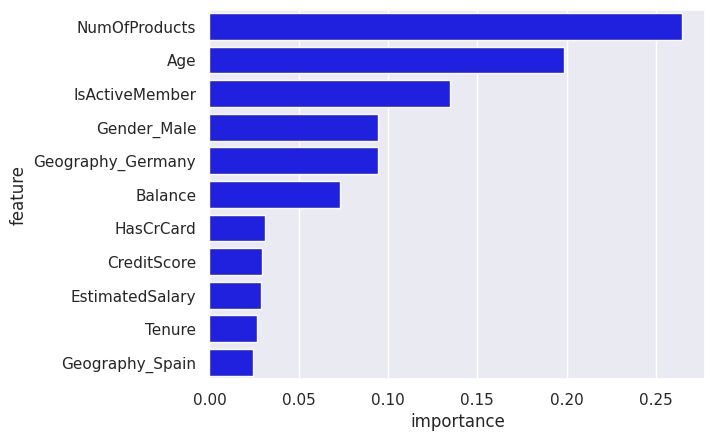

In [ ]:
sns.barplot(data=imp, y='feature', x='importance', color='b');

### **Summary**
---
- NumOfProducts memiliki nilai importance tertinggi (0.264477). Ini berarti fitur ini paling berpengaruh dalam memprediksi variabel target.
- Age juga signifikan (0.198300), menunjukkan usia pelanggan memiliki peran besar dalam hasil model.
- IsActiveMember memiliki pengaruh sedang (0.134966), artinya status keanggotaan aktif berkontribusi dalam prediksi.

In [ ]:
ct = pd.crosstab(df['HasCrCard'], df['Exited'])
ct

Exited,0,1
HasCrCard,,
0,2332,613
1,5631,1424


<Axes: xlabel='HasCrCard', ylabel='count'>

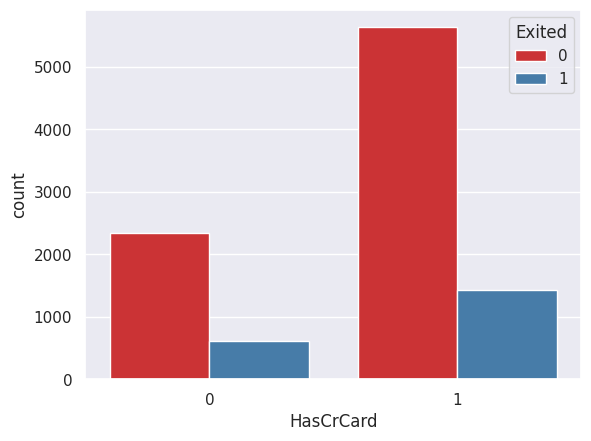

In [ ]:
sns.countplot(data=df, x='HasCrCard', hue='Exited')

<Axes: xlabel='NumOfProducts', ylabel='count'>

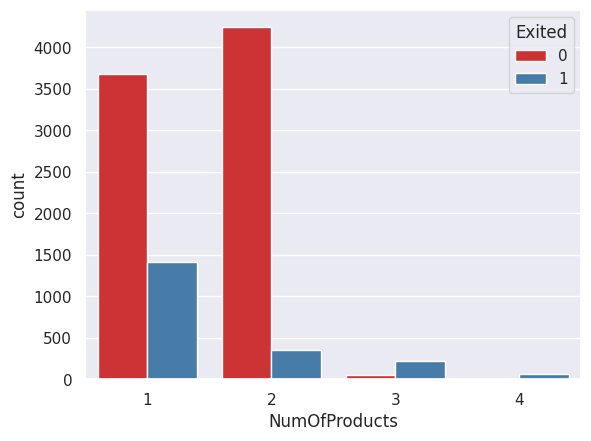

In [ ]:
sns.countplot(data=df, x='NumOfProducts', hue='Exited')